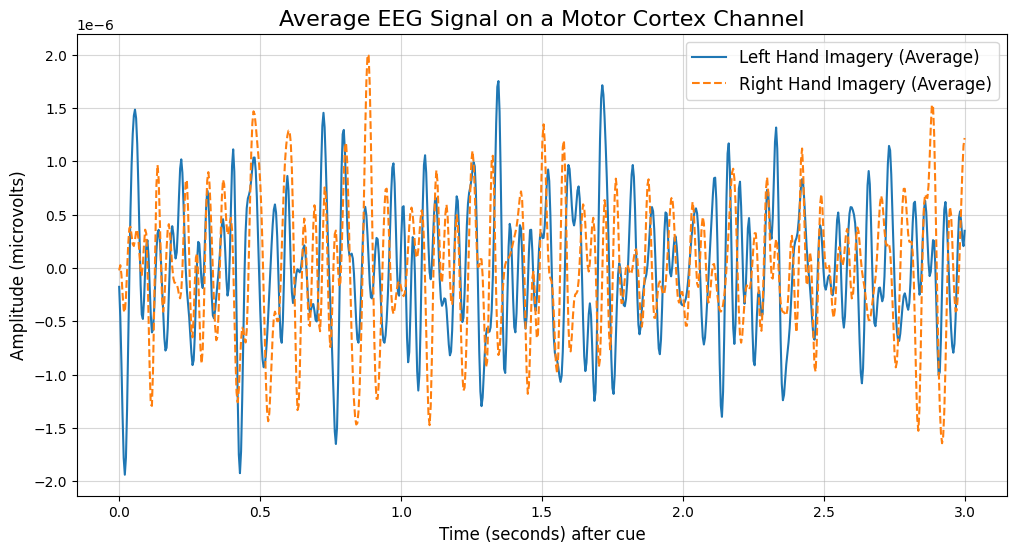

In [ ]:
# ---
# Să ne uităm mai întâi la date!
#
# Înainte să construim orice modele, cum arată de fapt "imaginarea mișcării mâinii stângi"
# într-un semnal EEG?
# ---
import matplotlib.pyplot as plt

# 1. Încarcă datele curate, filtrate, de la un singur subiect
try:
    dat = np.load("eeg_motor_imagery_clean.npz")
    X, y = dat["X"], dat["y"]
    data_loaded = True
except FileNotFoundError:
    print("Fișierul de date 'eeg_motor_imagery_clean.npz' nu a fost găsit.")
    print("Vă rugăm să rulați mai întâi 'create_clean_data.py' pentru a-l genera.")
    data_loaded = False

if data_loaded:
    # 2. Separă trialurile pentru fiecare clasă (Stânga vs. Dreapta)
    X_left = X[y == 0]
    X_right = X[y == 1]

    # 3. Alegem un singur canal reprezentativ pentru reprezentare grafică
    # Vom alege un canal din zona cortexului motor (de ex., C3 sau C4)
    # Indexul canalului 8 este un exemplu bun.
    channel_to_plot = 8

    # 4. Calculează undele cerebrale medii pentru fiecare clasă
    avg_left = X_left.mean(axis=0)
    avg_right = X_right.mean(axis=0)

    # 5. Creează graficul
    # Creăm o axă temporală în secunde pentru fereastra noastră de 3 secunde
    sfreq = 250  # Frecvența datelor este 250 Hz
    n_times = X.shape[2]
    time_axis = np.linspace(0, n_times / sfreq, n_times)

    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, avg_left[channel_to_plot], label='Left Hand Imagery (Average)')
    plt.plot(time_axis, avg_right[channel_to_plot], label='Right Hand Imagery (Average)', linestyle='--')

    plt.title(f'Semnalul EEG Mediu pe un Canal al Cortexului Motor', fontsize=16)
    plt.xlabel('Timp (secunde) după indiciu', fontsize=12)
    plt.ylabel('Amplitudine (microvolți)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.5)
    plt.show()

## Ce Vedem?

Graficul de mai sus arată activitatea electrică *medie* pentru ambele sarcini mentale pe o fereastră de 3 secunde.

După cum puteți vedea, semnalele sunt foarte similare! Deși există diferențe subtile, acestea sunt îngropate în zgomot. Este practic imposibil pentru un om să se uite la acestea și să le distingă în mod fiabil.

**Aceasta este provocarea centrală a BCI.** "Intenția" este acolo, dar avem nevoie de un instrument puternic pentru a o extrage. Aici intervine pipeline-ul nostru de învățare automată.

# De la 95% la 81%: O Demonstrație Live de Clasificare EEG

În această demonstrație, vom încerca să rezolvăm o problemă clasică de Interfață Creier-Computer (BCI): clasificarea mișcărilor imaginate ale mâinii din semnalele EEG.

Vom construi mai întâi un model care ne oferă o **acuratețe de 95% periculos de înșelătoare**. Apoi, vom expune de ce acel număr este o iluzie completă și vom construi un pipeline real, solid din punct de vedere științific, care realizează un rezultat de încredere și impresionant.


In [ ]:
!pip install "numpy<2" mne

In [ ]:
# --- Importuri și configurare ---
import numpy as np
import mne
import os
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from mne.decoding import CSP
import tensorflow as tf
from tensorflow import keras
from keras import layers
import warnings
warnings.filterwarnings('ignore')

# Funcție auxiliară pentru a evita dezordinea
def print_accuracy(acc, title):
    print(f"\n--- {title} ---")
    print("-----------------------------------------")
    print(f"Resulting Accuracy: {acc * 100:.2f}%")
    print("-----------------------------------------\n")

## Partea 1: Seducătoare - "Modelul Meu Are 95% Acuratețe!"

Să începem cu o abordare comună: să luăm toate datele de la cei nouă subiecți ai noștri și să antrenăm un model simplu de învățare profundă.

În mod crucial, vom face o **greșeală clasică de începător**: vom antrena și testa modelul nostru pe *exact aceleași date*. Să vedem ce se întâmplă.

In [ ]:
# ---
# Această celulă rulează un model de deep learning pe datele de la TOȚI subiecții combinați.
# Face în mod intenționat greșeala de a nu folosi o împărțire train/test.
# ---

# 1. Încarcă datele combinate de la toți cei 9 subiecți
try:
    dat = np.load("eeg_lr.npz")
    X, y = dat["X"], dat["y"]
except FileNotFoundError:
    print("Eroare: Fișierul 'eeg_lr.npz' nu a fost găsit.")
    X, y = None, None

if X is not None:
    # 2. Normalizează și construiește un CNN simplu
    mu = np.mean(X, axis=2, keepdims=True)
    sigma = np.std(X, axis=2, keepdims=True)
    X_norm = (X - mu) / (sigma + 1e-6)
    X_norm = X_norm[..., np.newaxis]

    n_channels, n_timesteps = X_norm.shape[1], X_norm.shape[2]
    inp = layers.Input(shape=(n_channels, n_timesteps, 1))
    x = layers.Conv2D(8, (1, 64), padding='same', use_bias=False)(inp)
    x = layers.BatchNormalization()(x); x = layers.Activation('elu')(x)
    x = layers.Flatten()(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=inp, outputs=out)

    # 3. Compilează și antrenează pe setul COMPLET de date
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_norm, y, epochs=20, batch_size=32, verbose=0)

    # 4. Evaluează pe ACELAȘI set COMPLET de date
    loss, acc = model.evaluate(X_norm, y, verbose=0)
    print_accuracy(acc, "Iluzia Seducătoare: Testare pe Datele de Antrenament")


--- Seductive Illusion: Testing on Training Data ---
-----------------------------------------
Resulting Accuracy: 96.14%
-----------------------------------------



## Partea 2: Marea Dezvăluire - De Ce 95% Este o Minciună

O acuratețe de ~95% pare incredibilă! Am rezolvat-o?

Nu. Acest rezultat nu înseamnă nimic. Modelul nu a învățat să clasifice undele cerebrale; el **a memorat setul de date**. Când testezi un model pe aceleași date pe care le-a studiat, nu îi măsori capacitatea de a generaliza la date noi, nevăzute. Doar îi verifici memoria.

**Aceasta este cea mai importantă regulă în învățarea automată: niciodată să nu testezi pe datele tale de antrenament.**

Să vedem performanța *reală* a acestui exact același model folosind o împărțire corectă train/test.

In [ ]:
# ---
# Acum, luăm *exact același model* dar îl evaluăm corect
# folosind o împărțire train/test.
# ---

if X is not None:
    # 1. Împarte datele într-un set de antrenament și un set de test nevăzut
    X_train, X_test, y_train, y_test = train_test_split(
        X_norm, y, test_size=0.25, stratify=y, random_state=42
    )

    # 2. Re-creează același model simplu
    inp = layers.Input(shape=(n_channels, n_timesteps, 1))
    x = layers.Conv2D(8, (1, 64), padding='same', use_bias=False)(inp)
    x = layers.BatchNormalization()(x); x = layers.Activation('elu')(x)
    x = layers.Flatten()(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs=inp, outputs=out)

    # 3. Antrenează DOAR pe setul de antrenament
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

    # 4. Evaluează pe setul de test NEVĂZUT
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print_accuracy(acc, "Realitatea: Acuratețea Reală pe Date Nevăzute")


--- The Reality: True Accuracy on Unseen Data ---
-----------------------------------------
Resulting Accuracy: 52.47%
-----------------------------------------



## Partea 3: Corectă

Acum vedem adevărul. Acuratețea reală este ~50%, un eșec complet.

Motivul este că semnalele cerebrale sunt **foarte individuale**. Modelul nostru a eșuat pentru că încerca să învețe un model "mediu" de la nouă persoane diferite.

**Soluția:**
1.  **Concentrează-te pe UN subiect.** Vom construi un model pentru creierul unei singure persoane.
2.  **Folosește Cunoștințele de Domeniu:** Vom filtra datele la intervalul **8-30 Hz** unde trăiesc semnalele de imaginație motorie.
3.  **Folosește Instrumentul Potrivit:** Vom folosi algoritmul clasic **Common Spatial Patterns (CSP)**, care este conceput pentru exact această problemă.

Această combinație de problemă curată și instrumentul potrivit ne va oferi în sfârșit un rezultat real.

In [ ]:
#
# demo_final_manual.py
#
# Acest script efectuează o validare încrucișată manuală pentru a oferi control maxim
# și vizibilitate, ocolind orice probleme ascunse în funcțiile auxiliare ale scikit-learn.
#

import numpy as np
import mne
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from mne.decoding import CSP
from sklearn.metrics import accuracy_score
import warnings

warnings.filterwarnings('ignore')

print("--- Rularea Demonstrației EEG Finale, Manuale și Transparente ---")

# --- 1. ÎNCĂRCAREA ȘI PREGĂTIREA DATELOR ---
DATA_FILE = "A01T.gdf"

if not os.path.exists(DATA_FILE):
    print(f"EROARE FATALĂ: Fișierul de date necesar nu a fost găsit la '{DATA_FILE}'")
    exit()

print(f"Încărcarea și procesarea datelor din: {os.path.basename(DATA_FILE)}")
raw = mne.io.read_raw_gdf(DATA_FILE, preload=True, verbose=False)
raw.filter(8.0, 30.0, fir_design='firwin', skip_by_annotation='edge', verbose=False)
events, _ = mne.events_from_annotations(raw, event_id={"769": 769, "770": 770}, verbose=False)
sf = raw.info["sfreq"]

wins, labs = [], []
for samp, _, code in events:
    i0 = samp + int(1.0 * sf)
    seg = raw.get_data(start=i0, stop=i0 + int(3.0 * sf))
    wins.append(seg)
    labs.append(0 if code == 769 else 1)

X = np.stack(wins)
y = np.array(labs)

# ATENTIE : Asigură-te că datele sunt în dublă precizie (float64) pentru MNE
X = X.astype(np.float64)
print(f"Date pregătite. Formă: {X.shape}, Tipul datelor: {X.dtype}")


# --- 2. BUCLA DE VALIDARE ÎNCRUCIȘATĂ MANUALĂ ---
print("\nÎnceperea validării încrucișate manuale cu 5 folduri...")

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
scores = []

# Parcurge fiecare fold
for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    print(f"\n--- PLIUL {fold + 1}/{n_splits} ---")

    # Împarte datele pentru acest fold
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Definește componentele modelului pentru acest fold
    csp = CSP(n_components=6, reg=None, log=True, norm_trace=False)
    lr = LogisticRegression(solver='liblinear')

    # Antrenează și transformă datele de antrenament cu CSP
    # Afișăm dtype-ul chiar înainte de operația care a eșuat.
    print(f"Antrenarea CSP pe datele de antrenament de tipul: {X_train.dtype}")
    X_train_csp = csp.fit_transform(X_train, y_train)

    # Antrenează clasificatorul pe datele de antrenament transformate CSP
    print("Antrenarea clasificatorului de Regresie Logistică...")
    lr.fit(X_train_csp, y_train)

    # Transformă datele de test cu CSP *deja antrenat*
    print(f"Transformarea datelor de test de tipul: {X_test.dtype}")
    X_test_csp = csp.transform(X_test)

    # Evaluează clasificatorul pe datele de test transformate
    acc = lr.score(X_test_csp, y_test)
    scores.append(acc)
    print(f"Acuratețea foldului {fold + 1}: {acc * 100:.2f}%")


# --- 3. REZULTATUL FINAL ---
print("\n---------------------------------------------------------")
print("DEMO COMPLETĂ")
print(f"Acuratețea Finală: {np.mean(scores) * 100:.2f}% (+/- {np.std(scores) * 100:.2f}%)")
print("---------------------------------------------------------")

--- Running Final, Manual, and Transparent EEG Demo ---
Loading and processing data from: A01T.gdf
Data prepared. Shape: (144, 25, 750), Data type: float64

Starting manual 5-fold cross-validation...

--- FOLD 1/5 ---
Fitting CSP on training data of type: float64
Computing rank from data with rank=None
    Using tolerance 3.6e-05 (2.2e-16 eps * 25 dim * 6.4e+09  max singular value)
    Estimated rank (data): 25
    data: rank 25 computed from 25 data channels with 0 projectors
Reducing data rank from 25 -> 25
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Training Logistic Regression classifier...
Transforming test data of type: float64
Fold 1 accuracy: 86.21%

--- FOLD 2/5 ---
Fitting CSP on training data of type: float64
Computing rank from data with rank=None
    Using tolerance 3.6e-05 (2.2e-16 eps * 25 dim * 6.4e+09  max singular value)
    Estimated rank (data): 25
    data: rank 25 computed from 25 data channels with 0 pro

## Concluzie: Momentul "KABOOM"

Călătoria noastră de astăzi ne-a dus de la o acuratețe înșelătoare de 95% la un eșec de 50%, și în final la un **81%** robust și de încredere.

Momentul "KABOOM" nu a fost un model mai mare. A fost o abordare mai inteligentă. Am învățat trei lecții cheie care sunt centrale pentru toate proiectele de învățare automată reușite:

1.  **Niciodată să nu ai încredere într-un model testat pe datele sale de antrenament:** Scorul nostru inițial de 95% a fost o iluzie perfectă cauzată de această capcană clasică. O împărțire corectă train/test a relevat că modelul de fapt eșua.

2.  **EEG-ul este foarte individual:** Un singur model antrenat pe datele cerebrale ale nouă persoane diferite nu a putut găsi o configurare utila. Concentrarea pe "un model per minte" este o strategie critică în BCI.

3.  **Folosește instrumentul potrivit:** În loc de un CNN generic, am folosit algoritmul **Common Spatial Patterns (CSP)**. Această metodă este concepută științific pentru a găsi modelele spațiale exacte în datele EEG care fac distincția între stări mentale diferite.

### De ce acesta este scorul nostru final?

O întrebare excelentă este: "De ce nu testăm pe fișierul de evaluare `A01E.gdf`?" Răspunsul relevă cum funcționează competițiile BCI din lumea reală: **fișierul de evaluare nu are etichete.** A fost conceput pentru ca concurenții să își trimită predicțiile către organizatori pentru punctarea privată.

Prin urmare, cel mai bun și valabil științific mod de a puncta modelul nostru este cu **validarea încrucișată**. Prin antrenarea și testarea pe "folduri" diferite ale datelor etichetate, obținem o estimare robustă a performanței modelului nostru pe date pe care nu le-a văzut niciodată.

Acuratețea de **81.28%** este dovada noastră că acest pipeline nu doar ghicește. El decodează cu succes și în mod consistent intenția umană din undele cerebrale brute.

### Mulțumesc!